In [78]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [79]:
# get input data
deepmimo = True

function_folder = "first_deepmimo_data"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

           0         1         2         3         4         5         6  \
0   0.900413  0.807999  0.999212  0.801931  0.716272  1.000000  0.938570   
1   0.917000  0.718554  1.000000  0.900072  0.600985  1.000000  0.902046   
2   0.874561  0.618652  1.000000  0.903942  0.521132  1.000000  1.000000   
3   1.000000  0.765392  1.000000  0.896352  0.506354  1.000000  0.911304   
4   0.958607  0.684986  1.000000  0.825572  0.280862  1.000000  1.000000   
..       ...       ...       ...       ...       ...       ...       ...   
75  0.931940  0.646086  1.000000  0.985910  0.536509  1.000000  0.866907   
76  0.974547  0.769854  1.000000  0.893029  0.791573  1.000000  0.942606   
77  1.000000  0.751634  1.000000  0.878520  0.559738  1.000000  0.917218   
78  0.957998  0.554091  1.000000  0.874929  0.425644  1.000000  0.982780   
79  1.000000  0.740936  1.000000  0.949140  0.661813  0.967738  0.913279   

           7         8         9  ...      1014      1015      1016      1017  \
0   0.

In [80]:
tensors['train'][1].shape

torch.Size([80, 1024])

# Evaluate KAN

In [81]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[4096, 10, 10, 4096]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0.01],
        'kan__deepmimo': [True]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1, 3, 3, 1]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0.01],
        'kan__deepmimo': [False]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=1,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)
# Fit RandomizedSearchCV
if not deepmimo:
    grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

    # Retrieve the best parameters and best score
    grid_search.best_params_['kan__data'] = []          # remove annoying print
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    opt_params_KAN = grid_search.best_params_
else:
    print(f"Deepmimo: {deepmimo}, not running cross-validation.....")


checkpoint directory created: ./model
saving model version 0.0
Deepmimo: True, not running cross-validation.....


In [82]:
# evaluate KAN with optimal params
if deepmimo:
    print(f"Deepmimo {deepmimo}, not running cross-val winning model again...")
else:
    kan_model = KANModel(width=[i[0] for i in opt_params_KAN['kan__width']], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'],deepmimo=deepmimo)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()

Deepmimo True, not running cross-val winning model again...


In [83]:
kan_model = KANModel(width=[1024, 80,80, 1024], grid=10, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=15)
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.11e-02 | test_loss: 3.88e-02 | reg: 3.54e+03 | : 100%|█| 15/15 [02:19<00:00,  9.27s/


saving model version 0.1


32
torch.Size([1, 1024])


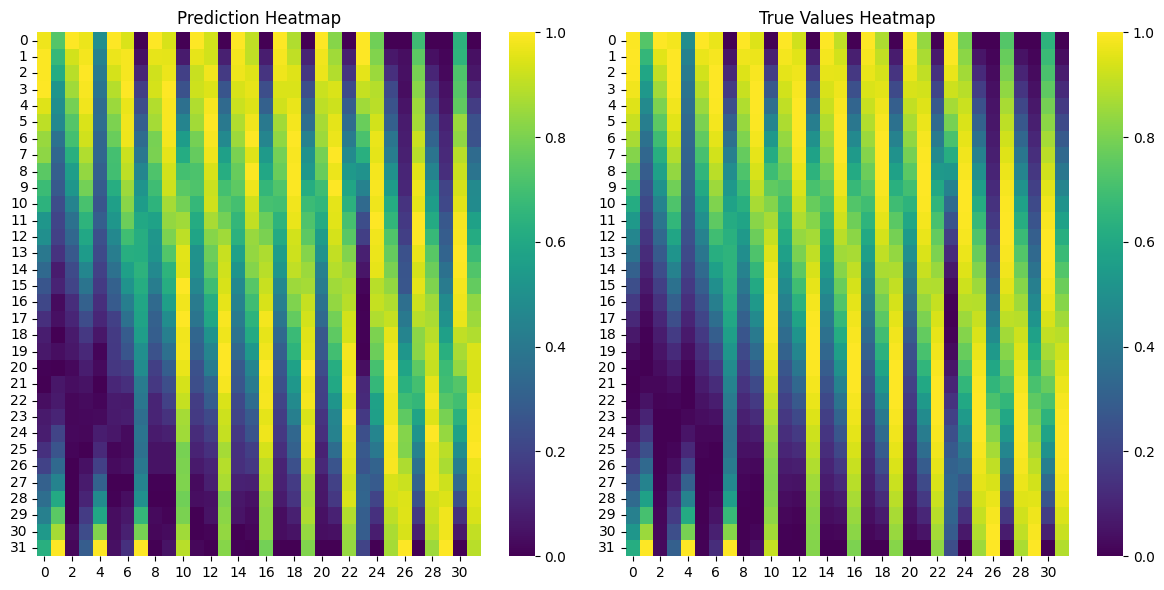

In [84]:
# plot pred and true
if deepmimo:
    kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)

32
torch.Size([1, 1024])


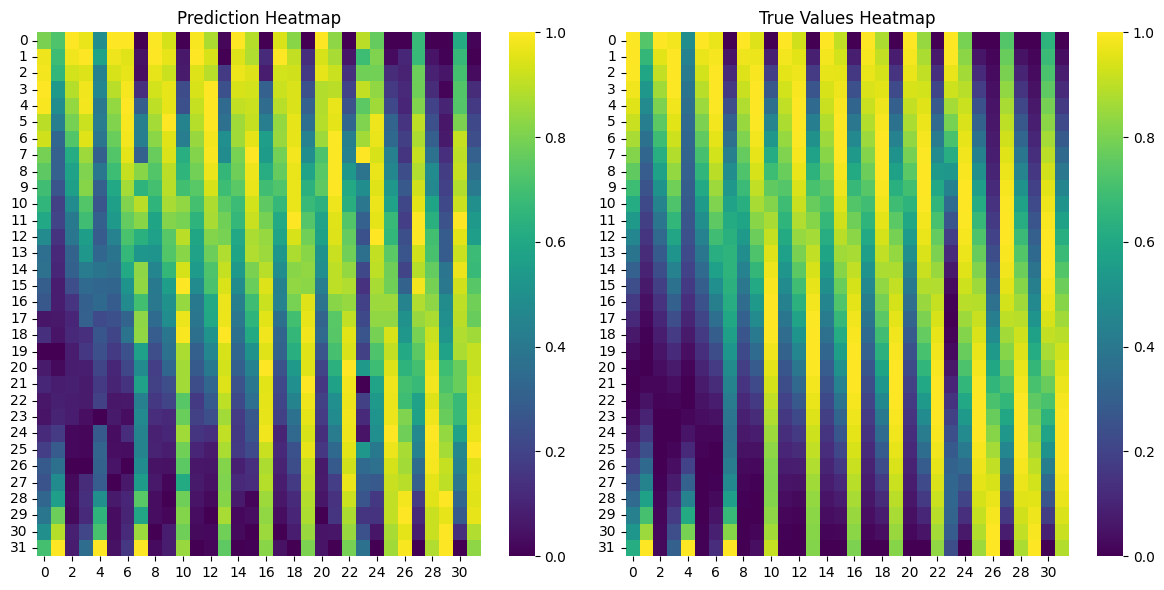

In [85]:
# plot noise and true
kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=False)

In [86]:
num_samples = tensors['test'][0].shape
noisy = tensors['test'][0] # [20, 1024]
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((noisy-true)**2, axis=1))
print(f"Average MSE per sample between noisy and true: {average_mse}")

Average MSE per sample between noisy and true: 6.213027000427246


In [87]:
# diffrence pred and true
num_samples = tensors['test'][0].shape
preds = y_preds['preds']
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
print(f"Average MSE per sample between predicted and true for KAN: {average_mse}")

Average MSE per sample between predicted and true for KAN: 1.5430301427841187


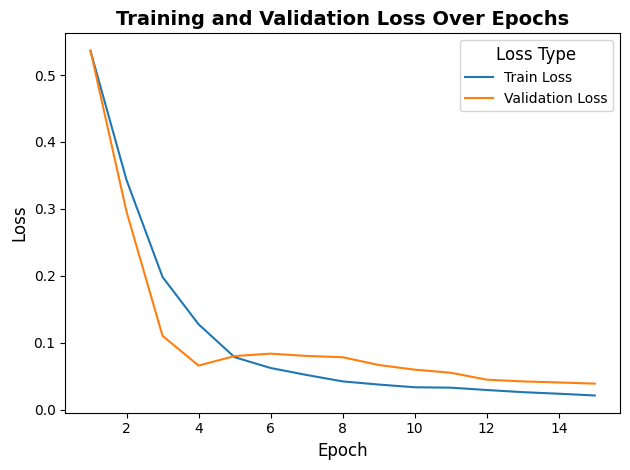

In [88]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [89]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[2000],[1000,1000],[300,300,300],[5000],[3000,3000],[32,32],[128,128],[256,64]],
        'mlp__output_size': [1024],
        'mlp__steps': [10000],
        'mlp__deepmimo': [True]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[3], [5],[5,3], [3,3,3]],
        'mlp__output_size': [1],
        'mlp__steps': [10000],
        'mlp__deepmimo': [False]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=1,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best scores
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  4%|▍         | 412/9999 [00:00<00:14, 672.54it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/9999 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y)

Best Parameters: {'mlp__steps': 10000, 'mlp__output_size': 1024, 'mlp__input_size': 1024, 'mlp__hidden_size': [128, 128], 'mlp__deepmimo': True, 'mlp__data': []}
Best Cross-Validation Score: -2.2272823763103133e-08


In [90]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'])
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=1000, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

100%|██████████| 999/999 [00:03<00:00, 273.25it/s]


In [91]:
# diffrence pred and true for MLP
num_samples = tensors['test'][0].shape
preds = y_preds_MLP['preds']
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
print(f"Average MSE per sample between predicted and true for MLP: {average_mse}")

Average MSE per sample between predicted and true for MLP: 0.1091962680220604


torch.Size([1, 1024])


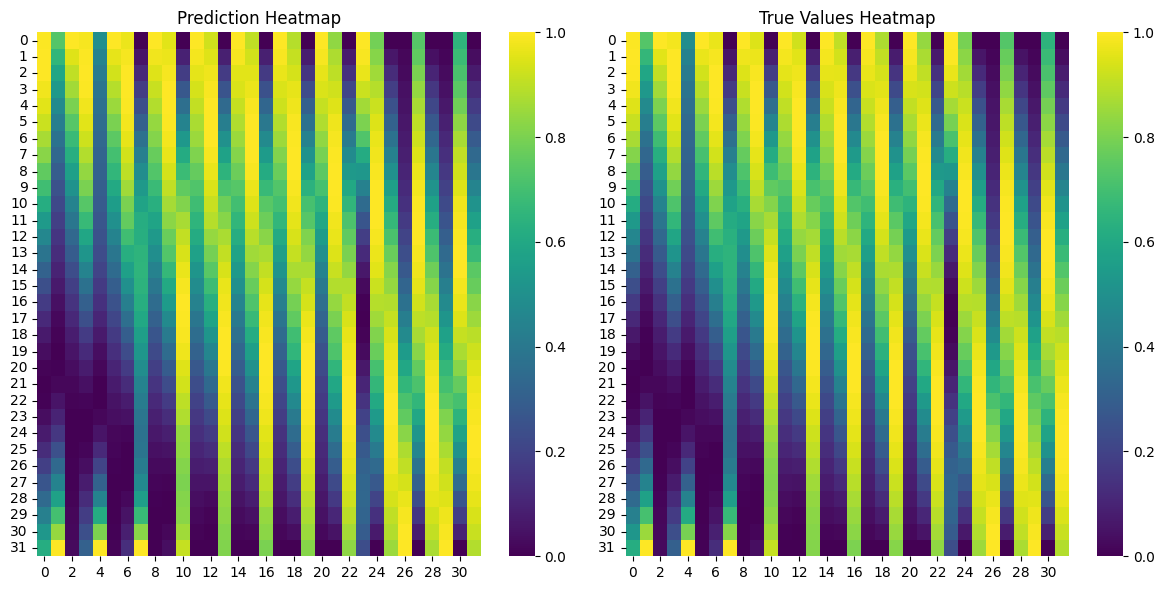

In [92]:
# plot predictions
if deepmimo:
    mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)

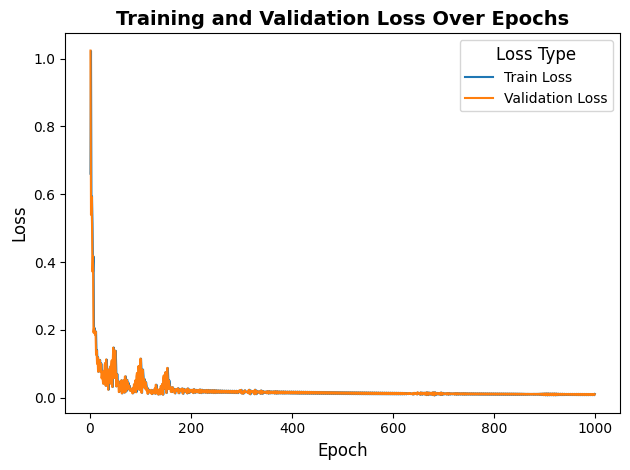

In [93]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=False,deepmimo=deepmimo)